In [1048]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# EDA

In [1049]:
#Importing dataset
df = pd.read_csv("Foreign_Exchange_Rates.csv")

In [1050]:
df.head()

,Unnamed: 0,Country/Currency,currency,value,date
0,0,Australia Dollar,AUD,1.581627,17-12-2021
1,1,Great Britain Pound,GBP,0.851619,17-12-2021
2,2,Euro,EUR,1.000000,17-12-2021
3,3,Japan Yen,JPY,128.301759,17-12-2021
4,4,Switzerland Franc,CHF,1.041015,17-12-2021


In [1051]:
df_INR = df.loc[df.currency == 'INR']
df_INR.head()

,Unnamed: 0,Country/Currency,currency,value,date
67,67,India Rupee,INR,86.052225,17-12-2021
217,217,India Rupee,INR,85.424708,18-12-2021
367,367,India Rupee,INR,85.424708,19-12-2021
517,517,India Rupee,INR,85.497443,20-12-2021
667,667,India Rupee,INR,85.525694,21-12-2021


In [1052]:
df.columns

Index(['Unnamed: 0', 'Country/Currency', 'currency', 'value', 'date'], dtype='object')

In [1053]:
# Let's remove the unwanted first column
df_INR = df_INR.drop(columns=df_INR.columns[0])

In [1054]:
df_INR.dtypes

Country/Currency     object
currency             object
value               float64
date                 object
dtype: object

In [1055]:
# converting date to datetime64[ns] type
df_INR['date'] = pd.to_datetime(df_INR['date'], format='%d-%m-%Y', dayfirst=True)

In [1056]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [1057]:
# As we are calculating for INR we don't need Country/Currency and currency column
df_INR = df_INR.drop(columns=df_INR.columns[:2])

In [1058]:
df_INR.head()

,value,date
67,86.052225,2021-12-17
217,85.424708,2021-12-18
367,85.424708,2021-12-19
517,85.497443,2021-12-20
667,85.525694,2021-12-21


In [1059]:
# We can get date month and year part from the date column
df_INR['month'] = df_INR['date'].dt.month
df_INR['year'] = df_INR['date'].dt.year
df_INR['day'] = df_INR['date'].dt.day
df_INR['day_of_week'] = df_INR['date'].dt.weekday

In [1060]:
df_INR.head()

,value,date,month,year,day,day_of_week
67,86.052225,2021-12-17,12,2021,17,4
217,85.424708,2021-12-18,12,2021,18,5
367,85.424708,2021-12-19,12,2021,19,6
517,85.497443,2021-12-20,12,2021,20,0
667,85.525694,2021-12-21,12,2021,21,1


In [1061]:
#Find the duplicates
df_INR.duplicated().sum()

0

In [1062]:
df_INR = df_INR.drop(['date'], axis=1)

In [1063]:
df_INR.dtypes

value          float64
month            int64
year             int64
day              int64
day_of_week      int64
dtype: object

# Chaos Test - Will be adding later

# ADF Test

In [1064]:
# check for Stationarity - ADF Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_INR['value'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.3001940814468083
p-value: 0.17190538402702799
Critial Values:
   1%, -3.450951662384033
Critial Values:
   5%, -2.8706147570800784
Critial Values:
   10%, -2.571604931640625


In [1065]:
"""
From ADF test, it's observed that, data is not stationary. 
We can see p-value is 17% (usually it must be less than 0.05 or 5%), 
and ADF-stat value is greater than all the critical values. 

Both these values confirms the data to be Non-Stationary
"""

"\nFrom ADF test, it's observed that, data is not stationary. \nWe can see p-value is 17% (usually it must be less than 0.05 or 5%), \nand ADF-stat value is greater than all the critical values. \n\nBoth these values confirms the data to be Non-Stationary\n"

# Splitting the dataset

In [1066]:
X = df_INR.iloc[:, 1:].values
y = df_INR.iloc[:, 0].values

In [1067]:
X.shape

(321, 4)

In [1068]:
y.shape

(321,)

In [1069]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [1070]:
# SMAPE function - Symmetric mean absolute percentage error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [1071]:
# Direction Symmetry - It gives the percentage of occurrences in which the sign of the change in value from one time period to the next is the same for both the actual and predicted time series
def ds(A, F):
    sum_A = 0
    for i in range(1, len(A)):
        sum_A += 1 if (A[i]-A[i-1])*(F[i]-F[i-1])>0 else 0
    return (100*sum_A)/(len(A)-1)

In [1072]:
# Theil's U coefficient - The greater accuracy of the forecast, the lower will be the value of the u1
def u1(A,F):
    data = pd.DataFrame({'A_i':A, 'F_i': F})
    data['(A_i - F_i)^2'] = np.square(data['A_i'] - data['F_i'])
    data['F_i^2'] = np.square(data['F_i'])
    data['A_i^2'] = np.square(data['A_i'])
    return (np.sqrt(np.mean(data['(A_i - F_i)^2'])))/(np.sqrt(np.mean(data['F_i^2']))+np.sqrt(np.mean(data['A_i^2'])))

# Linear Regression

In [1073]:
# Fitting Linear Regression in dataset
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [1074]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7418405361733843
MSE 1.106049122210072
RMSE 1.0516887002388453


 SMAPE prediction

In [1075]:
print(smape(y_test, y_pred))

1.0389807338320558


 Direction Symmetry prediction

In [1076]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [1077]:
print(u1(y_test, y_pred))

0.00637153165725196


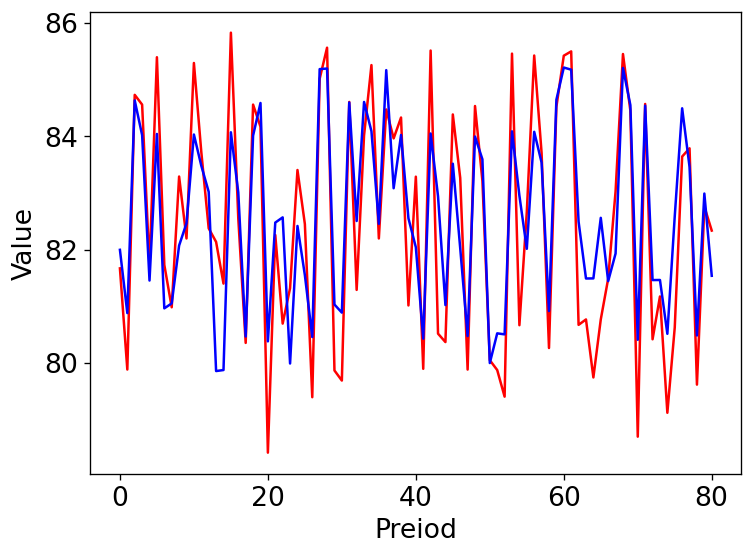

In [1078]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# Polynomial Regression

In [1079]:
# Fitting Polynomial Regression in dataset
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_trans, y_train)
y_pred = lr.predict(X_test_trans)

In [1080]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7497895432426632
MSE 1.0719926822055235
RMSE 1.0353707945492394


 SMAPE prediction

In [1081]:
print(smape(y_test, y_pred))

1.040735488675978


 Direction Symmetry prediction

In [1082]:
print(ds(y_test, y_pred))

83.75


 Theil's U coefficient prediction

In [1083]:
print(u1(y_test, y_pred))

0.0062726952798330465


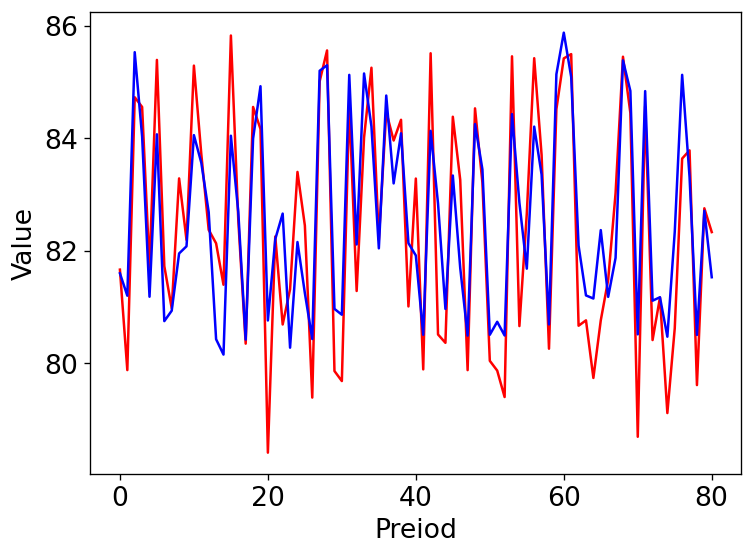

In [1084]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# XGB Regression

In [1085]:
from xgboost import XGBRegressor

In [1086]:
model = XGBRegressor()

In [1087]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [3, 4],
              "n_estimators": [100, 300, 1000],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 1000}


In [1088]:
regressor = XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [1089]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.9307336014383688
MSE 0.2967624668573032
RMSE 0.5447590906605444


 SMAPE prediction

In [1090]:
print(smape(y_test, y_pred))

0.5076731136771697


 Direction Symmetry prediction

In [1091]:
print(ds(y_test, y_pred))

90.0


 Theil's U coefficient prediction

In [1092]:
print(u1(y_test, y_pred))

0.0033008799662373935


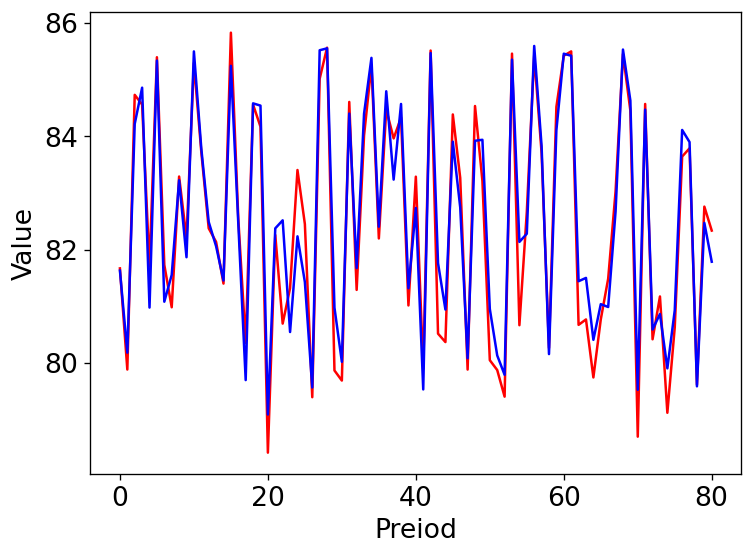

In [1093]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# SGD Regression

In [1094]:
from sklearn.linear_model import SGDRegressor

In [1095]:
from sklearn.pipeline import Pipeline

# Create a Pipeline object
sgd_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor()),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0], 
              'sgd__max_iter':[100, 500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001]
            }

# Create a GridSearchCV object and perform hyperparameter tuning
sgdr = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgdr.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgdr = sgdr.best_params_

print("Best Score (negative mean squared error): %f" % sgdr.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgdr)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best Score (negative mean squared error): -0.882180
Optimal Hyperparameter Values:  {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__l1_ratio': 1, 'sgd__max_iter': 1000}


In [1096]:
y_pred = sgdr.predict(X_test)

In [1097]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

R2 score:  0.7391719780227376
MSE 1.1174821967770057
RMSE 1.0571103049242334


 SMAPE prediction

In [1098]:
print(smape(y_test, y_pred))

1.0484053804817517


 Direction Symmetry prediction

In [1099]:
print(ds(y_test, y_pred))

81.25


 Theil's U coefficient prediction

In [1100]:
print(u1(y_test, y_pred))

0.006405029450235966


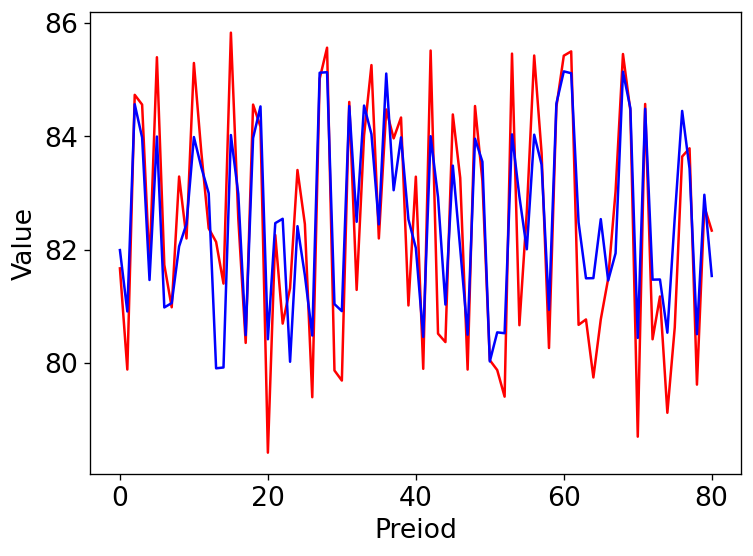

In [1101]:
plt.rc("figure")
plt.plot(y_test, color="r")
plt.plot(y_pred, color="b")
plt.xlabel("Preiod")
plt.ylabel("Value")
plt.show()

# LSTM

In [1102]:
# Splitting the dataset into the Training set and Test set
X = df_INR.iloc[:, 1:].values
y = df_INR.iloc[:, 0].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [1103]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [1104]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# define model
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1, 256)            267264    
                                                                 
 lstm_17 (LSTM)              (None, 128)               197120    
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 464,513
Trainable params: 464,513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
X_train = np.reshape(X_train, (X_train.shape[0], 1, 4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 4))
history = model.fit(X_train, y_train, epochs=25, batch_size=8, verbose=1, validation_split=0.1)

Epoch 1/25


In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

In [ ]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

In [ ]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

 SMAPE prediction

In [ ]:
print(smape(y_test, y_pred))

 Direction Symmetry prediction

In [ ]:
print(ds(y_test, y_pred))

 Theil's U coefficient prediction

In [ ]:
print(u1(y_test, y_pred))

In [ ]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# ANN 3-3-1

In [ ]:
# Splitting the dataset
X = df_INR.iloc[:, 1:].values
y = df_INR.iloc[:, 0].values

In [ ]:
# Building the Optimal Model using the Backward Elimination
import statsmodels.api as sm

X_values = np.append(arr=np.ones((X.shape[0], 1)).astype(int), values=X, axis=1)
X_opt = X_values[:, [0, 1, 2, 3]]
regressor_OLS = sm.OLS(endog=y, exog=X_opt).fit()
regressor_OLS.summary()

In [ ]:
# As we need only 3 dimensional input we will stop here by removing the column with highest p value
X_opt = X[:, [0,1,2]]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_opt, y, test_size=0.25, random_state=0)

In [ ]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(3, activation = 'relu', input_dim = 3))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

In [ ]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1, validation_split=0.1)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

In [ ]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

In [ ]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

 SMAPE prediction

In [ ]:
print(smape(y_test, y_pred))

 Direction Symmetry prediction

In [ ]:
print(ds(y_test, y_pred))

 Theil's U coefficient prediction

In [ ]:
print(u1(y_test, y_pred))

In [ ]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# ANN 4-4-1

In [ ]:
# Splitting the dataset
X = df_INR.iloc[:, 1:].values
y = df_INR.iloc[:, 0].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train.reshape(-1,1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# define model
model = Sequential()
model.add(Dense(4, activation = 'relu', input_dim = 4))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

In [ ]:
# fit model
history = model.fit(X_train, y_train, epochs=25, batch_size=10, verbose=1, validation_split=0.1)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
test_predict = sc_y.inverse_transform(test_predict)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

In [ ]:
# root mean squared error or rmse
import math
from sklearn.metrics import mean_squared_error

def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

train_score = measure_rmse(y_train, train_predict)
test_score = measure_rmse(y_test, test_predict)

print('Train and Test RMSE: ', train_score, test_score)

In [ ]:
import math
from sklearn.metrics import r2_score, mean_squared_error

print("R2 score: ", r2_score(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))

 SMAPE prediction

In [ ]:
print(smape(y_test, y_pred))

 Direction Symmetry prediction

In [ ]:
print(ds(y_test, y_pred))

 Theil's U coefficient prediction

In [ ]:
print(u1(y_test, y_pred))

In [ ]:
plt.rc("figure")
plt.rcParams.update({'font.size': 16})
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.xlabel('Period')
plt.ylabel('INR price')
plt.title('Currency price (INR) prediction using LSTM - Test data')
plt.legend()
plt.show()

# SARIMA

In [ ]:
# Analysing for seasonality
from datetime import datetime
INR_dataset = df.loc[df.currency == 'INR']
Date_column = [datetime.strptime(d, '%d-%m-%Y').strftime("%b %y") for d in INR_dataset['date']]
Day_column = [datetime.strptime(d, '%d-%m-%Y').strftime("%A") for d in INR_dataset['date']]

# Let's check for all the months for the exchange rate currency values in india
plt.figure(figsize=(12,6))
plt.plot(Date_column, INR_dataset['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for all months)')
plt.show()

The graph is neither increasing or decreasing based on the months. So, let's check it for a particular week.

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[:7], INR_dataset['value'][:7])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for first week)')
plt.show()

In week we get to see that the friday has the highest currency rate and it decreases as we move to weekends. So, let's check for multiple weeks and figure out about the days at which we get the higher currency rate from all the week days.

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[7:14], INR_dataset['value'][7:14])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for second week)')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(Day_column[14:21], INR_dataset['value'][14:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for third week)')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(INR_dataset['date'][:21], INR_dataset['value'][:21])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Checking seasonality between value and the date (for three week)')
plt.xticks(rotation=90)

As, we can see in the graph the rate of currency increases highly when we move from the december 31st, 2021 to January 1st 2022 and same when we have festivals like the currency rate rapidly increased when we have christmas on 25th or 26th december. 
Hence, SARIMA can help us to predict ouput currency rate based on the seasonality. 

In [ ]:
INR_dataset = INR_dataset.set_index('date')

In [ ]:
INR_dataset.dtypes

In [ ]:
INR_dataset = INR_dataset.iloc[:, -1:]
INR_dataset.head()

We have to calculate p, d, q, P, D, and Q value for the SARIMA to make the model for our forecasting

In [ ]:
# Finding the d value
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(INR_dataset.value); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(INR_dataset.value.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(INR_dataset.value.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In the first order differencing we have few noises than the second order differencing. So, we select the first order differencing for the model

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rcParams.update({'figure.figsize':(9,14), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(INR_dataset.value, ax=ax1)
plot_acf(INR_dataset.value.diff().dropna(), ax=ax2)
plot_acf(INR_dataset.value.diff().diff().dropna(), ax=ax3)
plt.show()

Here we can see that the second order differencing the immediate lag is gone to the negative side, representing that in second order the series has become over the difference.
Hence d = 1.

In [ ]:
#Finding the p value
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams.update({'figure.figsize':(7, 5), 'figure.dpi':120})
plot_pacf(INR_dataset.value.diff().dropna(), method='ywm')
plt.show()

Here we can see that the first lag is most significant than any other lags in the graph.
Hence p = 1.

In [ ]:
# Finding the q value

plot_acf(INR_dataset.value.diff().dropna())
plt.show()

Here we can see that only 1 of the lag is out of significant limit.
Hence q = 1.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(INR_dataset['value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(dis=-1)
print(model.summary())

In [ ]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
INR_dataset = df.loc[df.currency == 'INR']

In [ ]:
INR_dataset = INR_dataset.iloc[:, -2:]
INR_dataset.head()

In [ ]:
INR_dataset = INR_dataset.reset_index()

In [ ]:
forecast = model.predict(start=0, end=INR_dataset.shape[0] + 8)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(INR_dataset.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(INR_dataset['value'], label='actual')
plt.legend()
plt.show()

In [ ]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error

train = INR_dataset[:int(0.85*(len(INR_dataset)))]
test = INR_dataset[int(0.85*(len(INR_dataset))):]

start=len(train)
end=len(train)+len(test)-1
predictions = model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['value'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['value'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['value'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['value'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['value'])
                                                               /np.abs(test['value']))*100 
evaluation_results

In [ ]:
#Forecasting 2 years ahead
forecast_values = model.get_forecast(steps = 24)

INR_dataset = df.loc[df.currency == 'INR']

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = INR_dataset.plot(x='date', y='value', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Foreign Exchange Rate Currency Value, Monthly (till 2025)', size = 12)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left')
ax.axes.get_xaxis().set_visible(True)

plt.show()

Conclusion: From all the models I have tried the XGB regression was the best with R2 score around 93 none of the other models have score greater than 90 the SARIMA also have the score of 81 only.